In [1]:
!pip install adversarial-robustness-toolbox --extra pytorch
!pip install yolov5
!pip install datasets


Looking in indexes: https://pypi.org/simple, pytorch
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 21.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.13.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.4/953.4 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 646.6/646.6 kB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 14.0 MB/s eta 0:00:00
  Pr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.9 MB/s eta 0:00:00


In [39]:
import requests
import numpy as np
from PIL import Image
from io import BytesIO
import torch
import pandas as pd
import numpy as np
from torchvision.transforms import transforms
from tqdm import tqdm

from art.estimators.object_detection.pytorch_yolo import PyTorchYolo
from art.attacks.evasion import AdversarialPatchPyTorch


import cv2
import matplotlib
import matplotlib.pyplot as plt


plt.style.use('ggplot')
matplotlib.use( 'agg' )
%matplotlib inline


In [3]:
import yolov5
import datasets
import torch


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [5]:
rotation_max=0.0
scale_min=0.1
scale_max=0.3
distortion_scale_max=0.0
learning_rate=1.99
max_iter=200
batch_size=16
patch_shape=(3, 640, 640)
patch_location=None
patch_type="circle"
optimizer="pgd"


In [6]:
model = yolov5.load('keremberke/yolov5m-license-plate')
model = model.to(device)

model.conf = 0.25  # NMS confidence threshold
model.iou = 0.45  # NMS IoU threshold
model.agnostic = False  # NMS class-agnostic
model.multi_label = False  # NMS multiple labels per box
model.max_det = 1000  # maximum number of detections per image


config.json:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

best.pt:   0%|          | 0.00/42.1M [00:00<?, ?B/s]

In [36]:
CATEGORY_NAMES = ['license_plate']

def extract_predictions(predictions_, conf_thresh):
    # Get the predicted class
    predictions_class = [CATEGORY_NAMES[i] for i in list(predictions_["labels"])]
    #  print("\npredicted classes:", predictions_class)
    if len(predictions_class) < 1:
        return [], [], []
    # Get the predicted bounding boxes
    predictions_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(predictions_["boxes"])]

    # Get the predicted prediction score
    predictions_score = list(predictions_["scores"])
    # print("predicted score:", predictions_score)

    # Get a list of index with score greater than threshold
    threshold = conf_thresh
    predictions_t = [predictions_score.index(x) for x in predictions_score if x > threshold]
    if len(predictions_t) > 0:
        predictions_t = predictions_t  # [-1] #indices where score over threshold
    else:
        # no predictions esxceeding threshold
        return [], [], []
    # predictions in score order
    predictions_boxes = [predictions_boxes[i] for i in predictions_t]
    predictions_class = [predictions_class[i] for i in predictions_t]
    predictions_scores = [predictions_score[i] for i in predictions_t]
    return predictions_class, predictions_boxes, predictions_scores


def plot_image_with_boxes(img, boxes, pred_cls, title):
    text_size = 1
    text_th = 3
    rect_th = 2

    for i in range(len(boxes)):
        cv2.rectangle(img, (int(boxes[i][0][0]), int(boxes[i][0][1])), (int(boxes[i][1][0]), int(boxes[i][1][1])),
                      color=(0, 255, 0), thickness=rect_th)
        # Write the prediction class
        cv2.putText(img, pred_cls[i], (int(boxes[i][0][0]), int(boxes[i][0][1])), cv2.FONT_HERSHEY_SIMPLEX, text_size,
                    (0, 255, 0), thickness=text_th)

    plt.figure()
    plt.axis("off")
    plt.title(title)
    plt.imshow(img.astype(np.uint8), interpolation="nearest")
    plt.show()


In [50]:
dataset_name = 'keremberke/license-plate-object-detection'

hf_dataset = datasets.load_dataset(dataset_name, 'full')


from torchvision.transforms import functional as F
from torchvision.transforms import ToTensor
from torchvision import transforms
import numpy as np
import random
from torch.utils.data import DataLoader, Dataset

transform = transforms.Compose([
    transforms.Resize((640, 640), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor()

])


class HFDataset(Dataset):
    def __init__(self, hf_dataset, transforms=None):
        self.hf_dataset = hf_dataset
        self.transforms = transforms

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        image = item['image']

        if self.transforms:
            image = self.transforms(image).numpy()*255

        return image

dataset = HFDataset(hf_dataset['train'], transforms=transform)

def collate_fn(batch):
    return np.array(batch)

train_loader = DataLoader(dataset, batch_size=100, shuffle=True, collate_fn=collate_fn)


[[[        108         108         108 ...          39          39          39]
  [        108         108         108 ...          39          39          39]
  [        108         108         108 ...          39          39          39]
  ...
  [        155         155         155 ...         115         115         115]
  [        155         155         155 ...         115         115         115]
  [        155         155         155 ...         115         115         115]]

 [[         96          96          96 ...          71          71          71]
  [         96          96          96 ...          71          71          71]
  [         96          96          96 ...          71          71          71]
  ...
  [        141         141         141 ...          86          86          86]
  [        141         141         141 ...          86          86          86]
  [        141         141         141 ...          86          86          86]]

 [[        100         1

In [51]:

import yolov5
from yolov5.utils.loss import ComputeLoss


class Yolo(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.model.hyp = {'box': 0.05,
                        'obj': 1.0,
                        'cls': 0.5,
                        'anchor_t': 4.0,
                        'cls_pw': 1.0,
                        'obj_pw': 1.0,
                        'fl_gamma': 0.0
                        }
        self.compute_loss = ComputeLoss(self.model.model.model)

    def forward(self, x, targets=None):
        if self.training:
            outputs = self.model.model.model(x)
            loss, loss_items = self.compute_loss(outputs, targets)
            loss_components_dict = {"loss_total": loss}
            loss_components_dict['loss_box'] = loss_items[0]
            loss_components_dict['loss_obj'] = loss_items[1]
            loss_components_dict['loss_cls'] = loss_items[2]
            return loss_components_dict
        else:
            return self.model(x)

model = yolov5.load('keremberke/yolov5m-license-plate')

model = Yolo(model)

detector = PyTorchYolo(model=model,
                    device_type='cuda',
                    input_shape=(3, 640, 640),
                    clip_values=(0, 255),
                    attack_losses=("loss_total", "loss_cls",
                                    "loss_box",
                                    "loss_obj"))


In [53]:
dets = detector.predict(images)
for i in range(len(dets)):
    preds_orig = extract_predictions(dets[i], 0.8)
    # plot_image_with_boxes(img=images[i].transpose(1,2,0).copy(), boxes=preds_orig[1], pred_cls=preds_orig[0], title="Predictions on image without patch")


In [54]:
def filter_boxes(predictions, conf_thresh):
    dictionary = {}

    boxes_list = []
    scores_list = []
    labels_list = []

    for i in range(len(predictions[0]["boxes"])):
        score = predictions[0]["scores"][i]
        if score >= conf_thresh:
            boxes_list.append(predictions[0]["boxes"][i])
            scores_list.append(predictions[0]["scores"][[i]])
            labels_list.append(predictions[0]["labels"][[i]])

    if len(boxes_list) != 0:
        dictionary["boxes"] = np.vstack(boxes_list)
        dictionary["scores"] = np.hstack(scores_list)
        dictionary["labels"] = np.hstack(labels_list)
    else:
        dictionary["boxes"] = np.array([])
        dictionary["scores"] = np.array([])
        dictionary["labels"] = np.array([])

    y = [dictionary]

    return y

y = [filter_boxes([t], 0.8)[0] for t in dets]


In [32]:
from google.colab.patches import cv2_imshow


  0%|          | 0/100 [00:00<?, ?it/s]

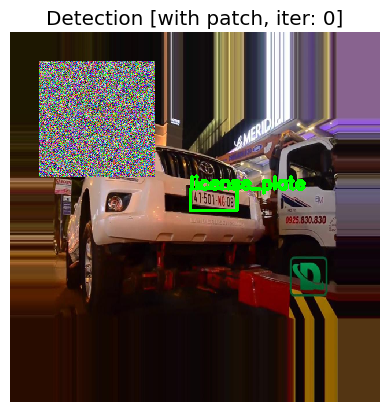

 40%|████      | 40/100 [00:25<00:34,  1.72it/s]

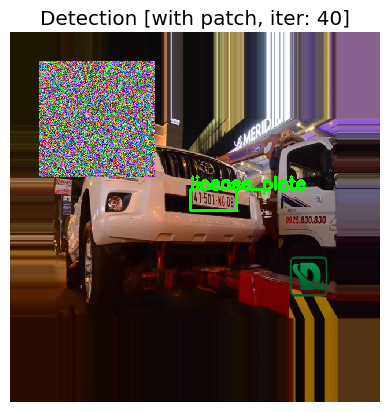

 80%|████████  | 80/100 [00:52<00:11,  1.73it/s]

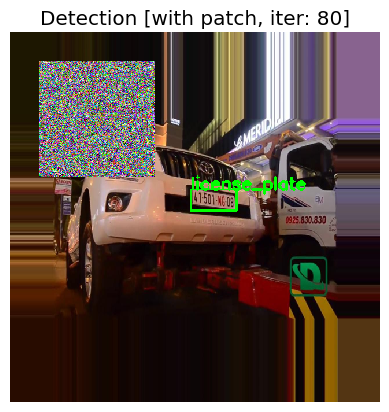

100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


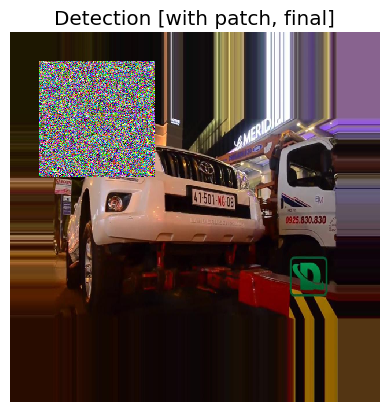

In [56]:
from art.attacks.evasion import RobustDPatch

x = images[:-1]
y = [y[-1] for i in range(len(images[:-1]))]

attack = RobustDPatch(
    detector,
    patch_shape=(3, 200, 200),
    patch_location=(50, 50),
    crop_range=[0,0],
    brightness_range=[1.0, 1.0],
    rotation_weights=[1, 0, 0, 0],
    sample_size=1,
    learning_rate=1.99,
    max_iter=1,
    batch_size=1,
    verbose=False,
    targeted=True
)

loss_history = []
for i in tqdm(range(100)):
    patch = attack.generate(x, y)
    patched_images = attack.apply_patch(x)

    loss_components, _ = detector._get_losses(patched_images, dets[:-1])
    losses = {}
    for loss in loss_components.keys():
        if 'loss' in loss:
            losses[loss] = loss_components[loss].item()
    loss_history.append(losses)

    if i%40==0:
        _y = detector.predict(patched_images)
        preds = extract_predictions(_y[0], 0.5)
        im = (patched_images[0].transpose(1,2,0)).astype(np.uint8)
        plot_image_with_boxes(img=im.astype(np.uint8).copy(), boxes=preds[1], pred_cls=preds[0], title=f"Detection [with patch, iter: {i}]")

_y = detector.predict(patched_images)
preds = extract_predictions(_y[0], 0.5)
im = (patched_images[0].transpose(1,2,0)).astype(np.uint8)
plot_image_with_boxes(img=im.astype(np.uint8).copy(), boxes=preds[1], pred_cls=preds[0], title=f"Detection [with patch, final]")


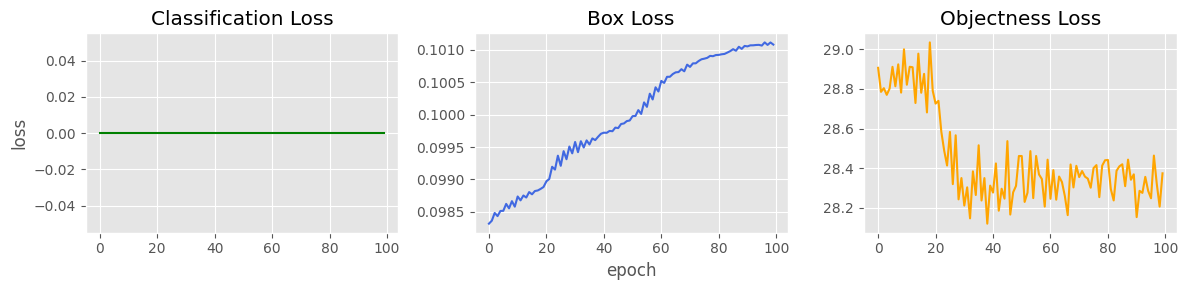

In [58]:
%matplotlib inline
losses = pd.DataFrame(loss_history)
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(12,3))
losses.loss_cls.plot(ylabel='loss', ax = axes[0], subplots=True, color='g')
losses.loss_box.plot(xlabel='epoch', ax = axes[1],subplots=True, color='royalblue')
losses.loss_obj.plot( ax = axes[2],subplots=True, color='orange')


axes[0].set_title('Classification Loss')
axes[1].set_title('Box Loss')
axes[2].set_title('Objectness Loss')
fig.tight_layout()


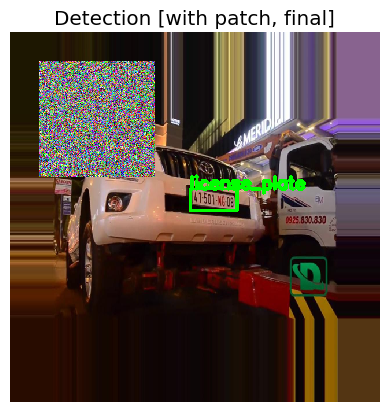

In [41]:
plot_image_with_boxes(img=im.astype(np.uint8).copy(), boxes=preds[1], pred_cls=preds[0], title=f"Detection [with patch, final]")


In [65]:
patched_images = attack.apply_patch(x)
for i in range(len(x)):
    _y_patched = detector.predict(patched_images)
    preds_patched = extract_predictions(_y_patched[i], 0.5)
    im_patched = (patched_images[i].transpose(1,2,0)).astype(np.uint8)
    plot_image_with_boxes(img=im_patched.astype(np.uint8).copy(), boxes=preds_patched[1], pred_cls=preds_patched[0], title=f"Detection with patch")

    _y = detector.predict(x)
    preds = extract_predictions(_y[i], 0.5)
    im = (x[i].transpose(1,2,0)).astype(np.uint8)
    plot_image_with_boxes(img=im.astype(np.uint8).copy(), boxes=preds[1], pred_cls=preds[0], title=f"Detection without patch")


Output hidden; open in https://colab.research.google.com to view.